In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from natsort import natsorted
import numpy as np
import matplotlib.animation as animation
import xarray as xr
import h5py
import imageio
import matplotlib
import gc
import sys
import io
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from scipy.optimize import curve_fit
import scipy.integrate

import scipy.ndimage

# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(rf'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM
plt.rcParams.update({'font.size': 22})  

tidy3dAPI = os.environ["API_TIDY3D_KEY"]
plt.rc('font', family='Arial')


In [2]:
folder_experimental = rf"H:\phd stuff\tidy3d\output\Experimental Data\data_lsu_air_decaline"
transmission_experimental_air = []
transmission_experimental_decaline = []

for filename in os.listdir(folder_experimental):
    if Path(filename).suffix == ".txt":
        continue

    with open(os.path.join(folder_experimental,filename), 'rb') as file:
        content = file.read()
        
    # Decode the binary content to a string
    decoded_content = content.decode('utf-8')

    # Split the content into lines
    lines = decoded_content.split('\r\n')

    # Initialize an empty list to store the parsed values
    data = []

    # Loop through each line and split by the comma
    for line in lines:
        if line:  # Skip any empty lines
            value1, value2 = line.split(',')
            data.append([float(value1), float(value2)])  # Convert values to float

    if "decaline" in filename:
        transmission_experimental_decaline.append((data))
    else: 
        transmission_experimental_air.append(data)


transmission_experimental_air = np.array(transmission_experimental_air)
transmission_experimental_decaline = np.array(transmission_experimental_decaline)

    

In [3]:
sizes_exp = [5.4,8.4,9.4,10.4,11.4,12.4,14.5,20.5]


In [4]:
indices_experimental = [4]
indices_simulations = [10]

In [5]:
structure_1 = AM.loadFromFile(key = tidy3dAPI, file_path=rf"H:\phd stuff\tidy3d\data\20250411 Far Field Transmission LSU 29_ff_5x_size_perm_9.0\z_incidence\ak4_1000_eps_9p0_phih5_0p30_phiL_0p29_size_1.txt",get_ref=True)
# structure_1 = AM.loadFromFile(key = tidy3dAPI, file_path=rf"H:\phd stuff\tidy3d\data\20250410 Far Field Transmission LSU 29_ff_5x_size_perm_9.0\z_incidence\ak4_1000_eps_9p0_phih5_0p30_phiL_0p29_size_1.txt",get_ref=True)





Configured successfully.


15:43:41 W. Europe Daylight Time WARNING: Field projection monitor 'far_field'  
                                 has observation points set up such that the    
                                 monitor is projecting backwards with respect to
                                 its 'normal_dir'. If this was not intentional, 
                                 please take a look at the documentation        
                                 associated with this type of projection monitor
                                 to check how the observation point coordinate  
                                 system is defined.                             

15:44:09 W. Europe Daylight Time WARNING: Structure at 'structures[0]' has      
                                 bounds that extend exactly to simulation edges.
                                 This can cause unexpected behavior. If         
                                 intending to extend the structure to infinity  
                                 along one dimension, use td.inf as a size      
                                 variable instead to make this explicit.        

                                 WARNING: Suppressed 19 WARNING messages.       

                                 WARNING: Field projection monitor 'far_field'  
                                 has observation points set up such that the    
                                 monitor is projecting backwards with respect to
                                 its 'normal_dir'. If this was not intentional, 
                                 please take a look at the documentation        
                                 associated with this type of projection monitor
                                 to check how the observation point coordinate  
                                 system is defined.                             

15:49:19 W. Europe Daylight Time Billed flex credit cost: 52.612.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

In [6]:
sim_data, sim_data0 = structure_1.sim_data, structure_1.sim_data0
projected_field_data_0 = sim_data0["far_field"].power.squeeze().values
projected_field_data = sim_data["far_field"].power.squeeze().values




In [7]:
r_proj=(sim_data0["far_field"].r)[0]
theta_proj=sim_data0["far_field"].theta
phi_proj=sim_data0["far_field"].phi
indices_0_30 = np.where(np.bool_(theta_proj*180/np.pi >=15) & np.bool_(theta_proj*180/np.pi <=30))[0]
r,theta,phi = r_proj,theta_proj[indices_0_30],phi_proj

In [8]:
nu_values = 3.4/(td.C_0/sim_data0["far_field"].f)

In [9]:
indices_degrees = np.where(np.bool_(theta_proj*180/np.pi >=15) & np.bool_(theta_proj*180/np.pi <=30))[0]

theta_slice = theta_proj[indices_degrees]
dtheta = np.diff(theta_slice)

theta_mid = 0.5 * (theta_slice[:-1] + theta_slice[1:]) 

dA = (r ** 2) * np.sin(theta_mid) * dtheta * np.diff(phi)[1]


In [10]:
transmission_0_15_degrees = ((projected_field_data_0[indices_degrees[:-1],:,:])* dA[:,np.newaxis,np.newaxis]).sum(axis=(0,1))

In [11]:
transmission_normalized_15_degrees = ((projected_field_data[indices_degrees[:-1],:,:])* dA[:,np.newaxis,np.newaxis]).sum(axis=(0,1))/transmission_0_15_degrees 

In [12]:
sigma_tilted =9
smoothed_transmission_15_degrees = scipy.ndimage.gaussian_filter1d(transmission_normalized_15_degrees, sigma_tilted)
sigma_physical = np.diff(nu_values)[0] * sigma_tilted
sigma_physical

0.026404602109300235

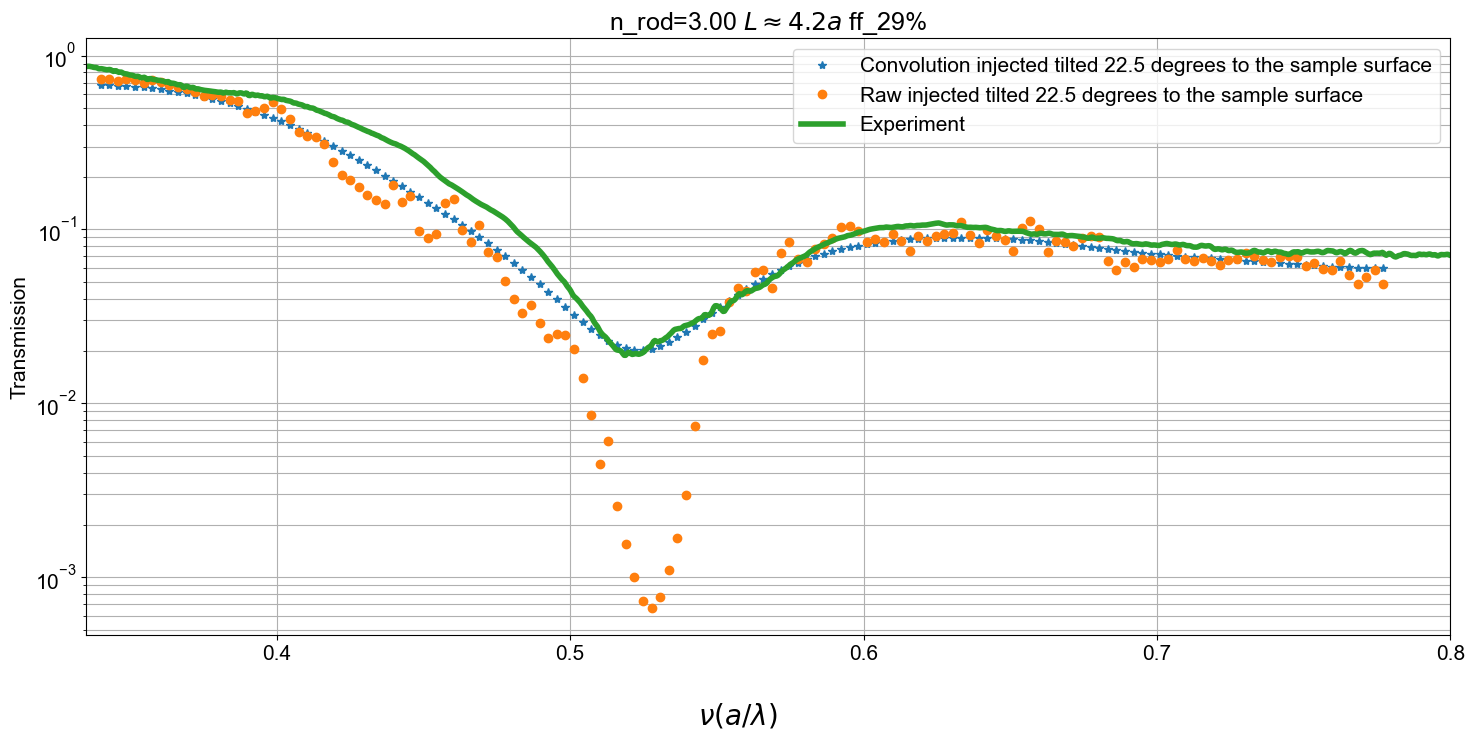

In [13]:
plt.rcParams.update({'font.size': 15})  
fig, ax = plt.subplots(figsize=(15, 7.5))

ax.plot(nu_values,smoothed_transmission_15_degrees,"*",label=rf"Convolution injected tilted 22.5 degrees to the sample surface")
ax.plot(nu_values,transmission_normalized_15_degrees,"o",label=rf"Raw injected tilted 22.5 degrees to the sample surface")

adjust =0.875
ax.plot(2.7*adjust/(1e4/transmission_experimental_air[4,:,0]),transmission_experimental_air[4,:,1],linewidth=4,label=rf"Experiment")
ax.legend(loc=1)
ax.grid(True, which="both")
ax.set_yscale("log")
ax.set_xlim(0.335,0.8)
ax.set_ylabel("Transmission")
ax.set_title(rf"n_rod={3:.2f} $L\approx 4.2a$ ff_29%")


fig.supxlabel(rf'$\nu (a/\lambda)$', fontsize=20)
plt.tight_layout()
plt.show()


In [16]:
transmission = np.array([np.transpose(nu_values),np.transpose(transmission_normalized_15_degrees),np.transpose(smoothed_transmission_15_degrees)])

np.savetxt(rf"transmission_far_field_22p5_degrees.txt", np.transpose(transmission) , fmt="%.18f", delimiter=" ", header="nu transmission_unfiltered transmission_filtered", comments="")

In [20]:
experimental_data =np.array([( 2.7*adjust/(1e4/transmission_experimental_air[4,:,0])),(transmission_experimental_air[4,:,1])])

np.savetxt(rf"transmission_experimental_L_4p2a.txt", np.transpose(experimental_data) , fmt="%.18f", delimiter=" ", header="nu transmission", comments="")


In [ ]:
# data = {
#                         'raw_power_reference':projected_field_data_0,
#                         'raw_power_transmitted':projected_field_data,
#                         'r':np.array([r]),
#                         'theta':theta_proj,
#                         'phi':phi_proj,
#                         'raw_frequencies':sim_data0["far_field"].f,
#                         'nu':nu_values,
#                         'normalized_transmission_15_30_degrees':transmission_normalized_15_degrees,
#                         'smoothed_transmission':smoothed_transmission_15_degrees
                        
#                   }



# create_hdf5_from_dict(data,rf"H:\phd stuff\tidy3d\output\LSU Data\far_field_ff_30_size_5x.h5")
      

In [ ]:
nu_values[13]

In [ ]:
import numpy as np
import plotly.graph_objects as go


theta, phi = np.meshgrid(theta_proj, phi_proj)

# Sample E_theta and E_phi (replace with your own arrays)
E_theta = (sim_data0["far_field"].Etheta.values)[:,:,:,13].squeeze() 
E_phi = (sim_data0["far_field"].Ephi.values)[:,:,:,13].squeeze()
# Compute intensity
intensity = np.abs(E_theta)**2 + np.abs(E_phi)**2
r=1
# Spherical to Cartesian conversion
x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)




In [ ]:
# Plot
fig = go.Figure(data=[go.Surface(
    x=x, y=y, z=z,
    surfacecolor=intensity.T,
    colorscale='turbo',
    cmin=0, cmax=np.max(intensity.T),
    showscale=True
)])

fig.update_layout(
    title=rf'Far-Field Transmitted Intensity nu={nu_values[13]:.4f}',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

In [ ]:
import numpy as np
import plotly.graph_objects as go



# Convert lines at 15 and 30 degrees (in radians)
theta_15 = np.radians(15)  # 15 degrees in radians
theta_30 = np.radians(30)  # 30 degrees in radians

# Parametric lines (phi goes from 0 to 2*pi)
phi_line = np.linspace(0, 2 * np.pi, 100)
x_line_15 = r * np.sin(theta_15) * np.cos(phi_line)
y_line_15 = r * np.sin(theta_15) * np.sin(phi_line)
z_line_15 = r * np.cos(theta_15) * np.ones_like(phi_line)  # Ensure it's an array

x_line_30 = r * np.sin(theta_30) * np.cos(phi_line)
y_line_30 = r * np.sin(theta_30) * np.sin(phi_line)
z_line_30 = r * np.cos(theta_30) * np.ones_like(phi_line)  # Ensure it's an array

# Plot
fig = go.Figure(data=[go.Surface(
    x=x, y=y, z=z,
    surfacecolor=intensity.T,
    colorscale='turbo',
    cmin=0, cmax=np.max(intensity.T),
    showscale=True
)])

# Add lines at 15 and 30 degrees
fig.add_trace(go.Scatter3d(
    x=x_line_15, y=y_line_15, z=z_line_15,
    mode='lines',
    line=dict(color='red', width=4),
    name='Line at 15 degrees'
))

fig.add_trace(go.Scatter3d(
    x=x_line_30, y=y_line_30, z=z_line_30,
    mode='lines',
    line=dict(color='blue', width=4),
    name='Line at 30 degrees'
))

fig.update_layout(
    title=rf'Far-Field Transmitted Intensity nu={nu_values[13]:.4f}',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()


In [ ]:
# data = {
#                         'Etheta_ref':sim_data0["far_field"].Etheta.values,
#                         'Ephi_ref':sim_data0["far_field"].Ephi.values,
#                         'Etheta':sim_data["far_field"].Etheta.values,
#                         'Ephi':sim_data["far_field"].Ephi.values,
#                         'r':np.array([r]),
#                         'theta':theta_proj,
#                         'phi':phi_proj,
#                         'nu':nu_values,
                        
#                   }



# create_hdf5_from_dict(data,rf"H:\phd stuff\tidy3d\output\LSU Data\Fields_far_field_ff_30_size_5x.h5")
      